In [1]:
from __future__ import print_function, division
import os,sys
import numpy as np
import torch # pytorch package, allows using GPUs
# fix seed
seed=17
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import datasets # load data
from torch.nn.utils.rnn import pad_sequence

all_data = 'ExpL project/MPSEQCN1.csv'
#all_data = 'ExpL project/MP_W_Seq.csv'
# Mapping for mechanical properties (assuming CSV columns [11,13,15,17] in this order)
target_property_index = {
    'toughness': 0,
    'youngs_modulus': 1,
    'tensile_strength': 2,
    'strain_at_break': 3
}
# Mapping: assign unique numbers (1-20) based on polarity order (least polar → most polar)
aa_to_polarity = {
    'L': 1,  # Leucine
    'F': 2,  # Phenylalanine
    'I': 3,  # Isoleucine
    'C': 4,  # Cysteine
    'M': 5,  # Methionine
    'V': 6,  # Valine
    'W': 7,  # Tryptophan
    'Y': 8,  # Tyrosine
    'P': 9,  # Proline
    'A': 10, # Alanine
    'T': 11, # Threonine
    'G': 12, # Glycine
    'S': 13, # Serine
    'H': 14, # Histidine
    'Q': 15, # Glutamine
    'R': 16, # Arginine
    'K': 17, # Lysine
    'N': 18, # Asparagine
    'E': 19, # Glutamic acid
    'D': 20  # Aspartic acid
}
# Reverse mapping to decode numbers back into amino acids.
polarity_to_aa = {v: k for k, v in aa_to_polarity.items()}
def sequence_to_polarity_numbers(seq, mapping=aa_to_polarity):
    """
    Convert an amino acid sequence to a list of unique integer values based on polarity.
    Amino acids not in the mapping will be assigned 0.
    """
    return [mapping.get(aa, 0) for aa in seq]

In [3]:
import argparse
import sys; sys.argv=['']; del sys  # for Jupyter notebooks

parser = argparse.ArgumentParser(
    description='PyTorch Regression Model: Predict a Mechanical Property from AA Sequences')
# ... (other arguments)
parser.add_argument('--target-property', type=str, choices=['toughness', 'youngs_modulus', 'tensile_strength', 'strain_at_break'],
                    default='strain_at_break', help='Mechanical property to predict')
# example values for other arguments:
parser.add_argument('--batch-size', type=int, default=32, metavar='N', help='Training batch size (default: 32)')
parser.add_argument('--test-batch-size', type=int, default=64, metavar='N', help='Test batch size (default: 64)')
parser.add_argument('--epochs', type=int, default=5, metavar='N', help='Number of epochs (default: 5)')
parser.add_argument('--lr', type=float, default=0.01, metavar='LR', help='Learning rate (default: 0.01)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M', help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False, help='Disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S', help='Random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=1, metavar='N', help='Batches between logging (default: 1)')
args = parser.parse_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()
print("Arguments:", args)


Arguments: Namespace(target_property='strain_at_break', batch_size=32, test_batch_size=64, epochs=5, lr=0.01, momentum=0.5, no_cuda=False, seed=1, log_interval=1, cuda=False)


Code notes:

Defining the dataset (Silkome_Dataset)
    
    - the class declaration will load the data from the all_data csv file and process it into a Pytorch format

__init__:
    
    - this initializes the dataset by taking the file path, data_type (ie train or test data), transform, test_size, and random_state (for reproducibility)
   
    - it reads the CSV file into a pd dataframe and then extracts the individual IDs from the first column (0)
    
    - it then extracts the mechanical properties from indexes 11, 13, 15, and 17, and converts it into a NumPy array, they are in 32-bit float format for easier numerical operations
   
    - the next part extracts and cleans up the sequence data, it extracts column 21 and replaces missing values with empty strings and converts it into a NumPy array
   
    - it loops through each row of sequence data and splits the string using ',' as the delimiter, it gets rid of empty strings
   
   
    - it also filters by length, just in case anything is longer or shorter than what the predetermined min and max lengths are, and it only allows a max of 2 sequences per ID, this can be changed as some have up to 8 sequences

Train/Test split:
   
    - data is split into training and testing data sets

__len__:
   
    - returns the number of samples in the dataset, pytorch uses this to know how many samples are available

__getitem__:
   
    - this method retrieves a sample at a certain index and retrieves the ID, the mechanical properties, and the amino acid sequence(s)
    it returns a dictionary with the keys: 'id', 'mechanical_props', and 'sequences'

custom_collate:
   
    - this handles the variable length sequences by converting the mechanical props into a tensor while keeping the IDs and sequences as lists
    
    - this was done due to the error I recieved from pytorch expecting every item in a batch to have the same shape, due to the variable lengths of the sequences, a collate function was used

load_data:
    
    - creates two data sets for training and testing, it wraps each dataset into a dataloader that will batch the data, shuffle the training data (not the test), use the collate function to handle batch size issues and returns the training and testing dataloaders

__name__:
   
    - example usage
    
    - prints the IDs, mechanical properties as a tensor, and the sequences
    

In [4]:
class Silkome_Dataset(Dataset):
    """Silkome pytorch dataset for the mechanical properties and amino acid sequences.
     Assumes:
      - uses a CSV file where:
          - index 0: Individual IDs.
          - indexes 11, 13, 15, 17: Mechanical properties 
            (in order: "toughness", "youngs_modulus", "tensile_strength", "strain_at_break").
          - index 21: Amino acid sequences concatenated from two columns.
            (Sequences are assumed to be separated by a comma ',')
      - Each cell in the sequence column must contain at least one sequence.
      - Maximum number of sequences per cell is 2.
      - Each sequence must have a length between 151 and 1515.
    """

    def __init__(self, all_data, data_type='train', transform=None, test_size=0.2, random_state=42):
        """
       Args:
            all_data (str): Path to the CSV file. (ExpL project/MP_W_Seq.csv)
            data_type (str): 'train' or 'test'. Use 'train' for the training set and 'test' for the testing set.
            transform (callable, optional): Optional transform to be applied on a sample.
            test_size (float): Fraction of data to use as test set.
            random_state (int): Seed for splitting.
        """
        self.df = pd.read_csv(all_data)
        
        # Extract individual IDs from column 0
        self.ids = self.df.iloc[:, 0].values

        # Extract mechanical properties from columns 11, 13, 15, 17
        self.mechanical_props = self.df.iloc[:, [11, 13, 15, 17]].values.astype(np.float32)

        # Process the amino acid sequences from column 21.
        # First, fill missing values (if any) with an empty string.
        raw_sequences = self.df["MaSp1"].fillna('').values

        processed_sequences = []
        polarity_numeric_sequences = []  # Store numeric representations based on polarity.
        for i, s in enumerate(raw_sequences):
            # Split on comma; adjust the delimiter if needed.
            seq_list = [seq.strip() for seq in s.split(',') if seq.strip() != '']
            
            # Filter each sequence by length (151 to 1515 AAs)
            valid_seqs = [seq for seq in seq_list if 151 <= len(seq) <= 1515]
            #print (valid_seqs)
            
            processed_sequences.append(valid_seqs)
            
            # Convert each valid sequence to its numeric representation based on polarity.
            numeric_seq_list = [sequence_to_polarity_numbers(seq) for seq in valid_seqs]
            polarity_numeric_sequences.append(numeric_seq_list)
        #print("Length of IDs:", len(self.ids))
        #print("Length of processed sequences:", len(processed_sequences))
        #print("DataFrame shape:", self.df.shape)
        #print("Columns:", self.df.columns)
        #print("Raw sequences array length:", len(raw_sequences))
        #print("First few raw sequences:", raw_sequences[:5])

        
        self.sequences = processed_sequences
        self.polarity_numeric_sequences = polarity_numeric_sequences
        
        #train/test split
        if data_type in ['train', 'test']:
            indices = np.arange(len(self.ids))
            train_idx, test_idx = train_test_split(indices, test_size=test_size, random_state=random_state)
            if data_type == 'train':
                sel = train_idx
                print("Using training set (80% of data)")
            else:
                sel = test_idx
                print("Using testing set (20% of data)")
            
            self.ids = self.ids[sel]
            self.mechanical_props = self.mechanical_props[sel]
            self.sequences = [self.sequences[i] for i in sel]
            self.polarity_numeric_sequences = [self.polarity_numeric_sequences[i] for i in sel]
        
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        sample = {
            'id': self.ids[idx],
            'mechanical_props': self.mechanical_props[idx],  # ex, a numpy array of shape (4,)
            #'sequences': self.sequences[idx],  # list of one to eight sequences (strings)
            'polarity_numeric_sequences': self.polarity_numeric_sequences[idx]
        }
        if self.transform:
            sample = self.transform(sample)
        return sample

def custom_collate(batch):
    """
    Converts a batch from the dataset (with keys:
      - 'id'
      - 'mechanical_props': vector of 4 values per sample
      - 'polarity_numeric_sequences': list of sequences (each a list of ints)
    )
    into a dictionary with keys:
      - 'sequence': a padded LongTensor of shape (batch, max_len) using the first sequence.
      - 'mechanical_input': auxiliary mechanical input (can be chosen as needed).
      - 'target': the chosen mechanical property to predict.
    """
    import torch
    batch_ids = [item['id'] for item in batch]
    batch_mech = torch.stack([torch.tensor(item['mechanical_props']) for item in batch])
    
    # Select the target property using the index from mapping.
    target_idx = target_property_index[args.target_property]
    batch_target = batch_mech[:, target_idx].unsqueeze(1)
    
    # For the sequence, take the first available numeric sequence from each sample.
    batch_sequence = [
        item['polarity_numeric_sequences'][0] if len(item['polarity_numeric_sequences']) > 0 else []
        for item in batch
    ]
    
    max_len = 200  # Fixed padded sequence length.
    padded_sequences = []
    for seq in batch_sequence:
        seq_tensor = torch.tensor(seq, dtype=torch.long)
        if seq_tensor.numel() < max_len:
            pad = torch.zeros(max_len - seq_tensor.numel(), dtype=torch.long)
            padded_seq = torch.cat([seq_tensor, pad])
        else:
            padded_seq = seq_tensor[:max_len]
        padded_sequences.append(padded_seq)
    batch_sequence_tensor = torch.stack(padded_sequences)  # shape: (batch, max_len)
    
    auxiliary_idx = 3  #PROP TO PREDICT
    batch_mechanical_input = batch_mech[:, auxiliary_idx].unsqueeze(1)  # shape: (batch, 1)
    
    return {
        'id': batch_ids,
        'sequence': batch_sequence_tensor,
        'mechanical_input': batch_mechanical_input,
        'target': batch_target
    }


def load_data(all_data, batch_size, test_batch_size, **kwargs):
    """
    Create PyTorch DataLoaders for training and testing from the CSV file.
    
    Args:
        all_data (str): Path to the CSV file.
        batch_size (int): Batch size for the training loader.
        test_batch_size (int): Batch size for the test loader.
        **kwargs: Additional arguments for DataLoader (e.g., num_workers, pin_memory).
    
    Returns:
        train_loader, test_loader: DataLoader objects.
    """
    train_dataset = Silkome_Dataset(all_data=all_data, data_type='train')
    test_dataset = Silkome_Dataset(all_data=all_data, data_type='test')
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                              collate_fn=custom_collate, **kwargs)
    test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, 
                             collate_fn=custom_collate, **kwargs)

    
    return train_loader, test_loader

# Example usage:
if __name__ == "__main__":
    csv_path = 'ExpL project/MPSEQCN1.csv'
    train_loader, test_loader = load_data(csv_path, batch_size=32, test_batch_size=32)
    
    # Iterate through one batch from the training loader and print a sample
    for batch in train_loader:
        print("IDs:", batch['id'])
        print("Mechanical properties:", batch['mechanical_input'])
        print("Sequences:", batch['sequence'])
        break

Using training set (80% of data)
Using testing set (20% of data)
IDs: [6019, 3883, 4007, 7303, 5239, 5104, 6713, 2801, 2156, 6755, 4910, 5337, 5804, 6748, 3899, 3393, 1894, 3819, 5118, 2664, 6329, 2158, 6266, 4542, 5219, 5457, 3469, 5290, 7302, 6795, 5249, 3793]
Mechanical properties: tensor([[15.2000],
        [15.3000],
        [13.1000],
        [22.5000],
        [21.7000],
        [29.2000],
        [25.6000],
        [16.5000],
        [17.6000],
        [28.2000],
        [23.2000],
        [31.1000],
        [ 8.7000],
        [23.7000],
        [17.0000],
        [16.6000],
        [12.1000],
        [18.4000],
        [14.4000],
        [25.0000],
        [12.3000],
        [16.3000],
        [18.9000],
        [11.9000],
        [30.9000],
        [34.5000],
        [19.7000],
        [13.2000],
        [23.7000],
        [13.3000],
        [13.7000],
        [23.6000]])
Sequences: tensor([[15, 12, 12,  ..., 15, 12, 12],
        [10, 10, 10,  ..., 12, 13, 12],
        [ 5, 1

Defining the Neural Network and its Architecture

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, vocab_size=21, embedding_dim=32, max_len=200, 
                 conv_out_channels=64, hidden_dim_seq=128, hidden_dim_combined=64):
        """
        Args:
            vocab_size (int): Number of unique tokens (e.g. 21 if you map AAs 1-20, 0 for padding).
            embedding_dim (int): Dimension of the embedding vectors.
            max_len (int): Fixed length for padded amino acid sequences.
            conv_out_channels (int): Number of output channels for the 1D convolution.
            hidden_dim_seq (int): Size of the intermediate representation from the sequence branch.
            hidden_dim_combined (int): Size of the combined hidden layer.
            
        The model processes a padded, numeric sequence (shape: [batch, max_len]) and 
        a mechanical property input (shape: [batch, 1]) and outputs a single continuous prediction.
        """
        super(Model, self).__init__()
        # Embedding layer to convert token indices to embeddings.
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=0)
        
        # 1D Convolution over the sequence dimension.
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=conv_out_channels,
                               kernel_size=3, padding=1)
        # 1D max pooling to reduce sequence length.
        self.pool = nn.MaxPool1d(kernel_size=2)
        
        # Calculate the pooled sequence length.
        pooled_len = max_len // 2  # This assumes max_len is even.
        
        # Fully connected layer to obtain a fixed-length representation from the sequence.
        self.fc_seq = nn.Linear(conv_out_channels * pooled_len, hidden_dim_seq)
        
        # Fully connected layer to combine the sequence representation and mechanical input.
        self.fc_combined = nn.Linear(hidden_dim_seq + 1, hidden_dim_combined)
        
        # Output layer: predict one continuous value (the target mechanical property).
        self.fc_out = nn.Linear(hidden_dim_combined, 1)
        
    def forward(self, sample):
        """
        Args:
            sample (dict): Should contain:
                - 'sequence': Long tensor of shape (batch, max_len) containing the padded, numerically encoded sequence.
                - 'mechanical_input': Tensor of shape (batch, 1) with the extra mechanical property.
                
        Returns:
            Tensor of shape (batch, 1) with the predicted continuous value.
        """
        # Extract inputs.
        seq = sample['sequence']           # shape: (batch, max_len)
        mech = sample['mechanical_input']  # shape: (batch, 1)
        
        # Process the sequence.
        # Embedding: (batch, max_len) --> (batch, max_len, embedding_dim)
        x = self.embedding(seq)
        # Permute to shape: (batch, embedding_dim, max_len) for convolution.
        x = x.permute(0, 2, 1)
        # Convolution and ReLU activation.
        x = F.relu(self.conv1(x))
        # Max pooling reduces the sequence length.
        x = self.pool(x)  # shape: (batch, conv_out_channels, max_len//2)
        # Flatten the convolution output.
        x = x.view(x.size(0), -1)
        # Fully connected layer to obtain sequence representation.
        x_seq = F.relu(self.fc_seq(x))
        
        # Concatenate the sequence representation with the mechanical property.
        x_comb = torch.cat([x_seq, mech], dim=1)
        x_comb = F.relu(self.fc_combined(x_comb))
        output = self.fc_out(x_comb)
        return output

# Example usage:
if __name__ == "__main__":
    # Instantiate the model.
    # Here we use a smaller max_len for demonstration purposes.
    model = Model(vocab_size=21, embedding_dim=32, max_len=200, 
                  conv_out_channels=64, hidden_dim_seq=128, hidden_dim_combined=64)
    
    # Dummy input:
    # Create a dummy batch of 32 sequences, each padded to length 200.
    dummy_sequence = torch.randint(0, 21, (32, 200))
    # Create a dummy batch of 32 mechanical input values.
    dummy_mechanical = torch.randn(32, 1)
    
    dummy_input = {'sequence': dummy_sequence, 'mechanical_input': dummy_mechanical}
    
    # Get predictions.
    predictions = model(dummy_input)
    print("Predictions shape:", predictions.shape)  # Expected shape: (32, 1)


Predictions shape: torch.Size([32, 1])


In [6]:
from tqdm import tqdm
import torch.nn.functional as F

def train(epoch):
    model.train()  # Set model to training mode (affects Dropout, BatchNorm, etc.)
    for batch_idx, sample in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}")):
        # Move each tensor in the sample dictionary to GPU if needed.
        if args.cuda:
            sample = {key: value.cuda() if isinstance(value, torch.Tensor) else value 
                      for key, value in sample.items()}
        
        optimizer.zero_grad()
        output = model(sample)  # The model expects a dictionary input.
        
        # Compute the mean squared error between predictions and target values.
        loss = F.mse_loss(output, sample['target'])
        
        loss.backward()
        
        # Apply gradient clipping to prevent exploding gradients:
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        if batch_idx % args.log_interval == 0:
            # Calculate number of samples processed so far.
            processed = batch_idx * sample['target'].size(0)
            total = len(train_loader.dataset)
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, processed, total,
                100. * batch_idx / len(train_loader), loss.item()))

def test(data_loader, verbose='Test'):
    model.eval()  # Set model to evaluation mode.
    test_loss = 0
    with torch.no_grad():
        for sample in data_loader:
            if args.cuda:
                sample = {key: value.cuda() if isinstance(value, torch.Tensor) else value 
                          for key, value in sample.items()}
            output = model(sample)
            # Sum the MSE loss over the batch.
            test_loss += F.mse_loss(output, sample['target'], reduction='sum').item()
    
    test_loss /= len(data_loader.dataset)
    print('\n{} set: Average loss: {:.4f}\n'.format(verbose, test_loss))
    return test_loss


In [7]:
import torch.nn.functional as F
import torch.optim as optim

# load data using your load_data function (which already applies custom_collate)
train_loader, test_loader = load_data(all_data, batch_size=args.batch_size, test_batch_size=args.test_batch_size)

test_array = []
critical_array = []  # if you have a critical_loader defined

# We will vary the convolutional layer's depth (conv_out_channels) with values from N_array.
N_array = [1, 5, 10, 20, 50]

for N in N_array:
    # Instantiate the regression model.
    # Here, max_len is the fixed padded length for your sequence,
    # vocab_size=21 assumes tokens 1-20 for amino acids (0 used for padding).
    model = Model(vocab_size=21, embedding_dim=32, max_len=200, 
                  conv_out_channels=N, hidden_dim_seq=128, hidden_dim_combined=64)
    if args.cuda:
        model = model.cuda()

    # For regression, we'll use MSE loss inside the train/test functions.
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    
    # Train the model for a fixed number of epochs.
    for epoch in range(1, args.epochs + 1):
        train(epoch)  # Your train() function should use `model` and `optimizer`
        
        # At the final epoch, store the test losses.
        if epoch == args.epochs:
            test_loss = test(test_loader, verbose='Test')
            test_array.append(test_loss)
    
    print("For conv_out_channels =", N)
    print("Test losses:", test_array)

Using training set (80% of data)
Using testing set (20% of data)


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 1 [0/140 (0%)]	Loss: 487.821167
Train Epoch: 1 [32/140 (20%)]	Loss: 386.732117


Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 53.43it/s]


Train Epoch: 1 [64/140 (40%)]	Loss: 425.427795
Train Epoch: 1 [96/140 (60%)]	Loss: 369.636658
Train Epoch: 1 [48/140 (80%)]	Loss: 359.202850


Epoch 2:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 2 [0/140 (0%)]	Loss: 401.882874
Train Epoch: 2 [32/140 (20%)]	Loss: 376.958130
Train Epoch: 2 [64/140 (40%)]	Loss: 305.252136


Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 71.34it/s]


Train Epoch: 2 [96/140 (60%)]	Loss: 345.347015
Train Epoch: 2 [48/140 (80%)]	Loss: 545.648438


Epoch 3:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 3 [0/140 (0%)]	Loss: 354.717834
Train Epoch: 3 [32/140 (20%)]	Loss: 428.537079
Train Epoch: 3 [64/140 (40%)]	Loss: 284.551575


Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 71.69it/s]

Train Epoch: 3 [96/140 (60%)]	Loss: 279.305664
Train Epoch: 3 [48/140 (80%)]	Loss: 287.514526



Epoch 4:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 4 [0/140 (0%)]	Loss: 286.559753
Train Epoch: 4 [32/140 (20%)]	Loss: 346.189056
Train Epoch: 4 [64/140 (40%)]	Loss: 270.460297


Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 77.97it/s]


Train Epoch: 4 [96/140 (60%)]	Loss: 278.173553
Train Epoch: 4 [48/140 (80%)]	Loss: 199.861572


Epoch 5:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 5 [0/140 (0%)]	Loss: 287.410675
Train Epoch: 5 [32/140 (20%)]	Loss: 229.941635
Train Epoch: 5 [64/140 (40%)]	Loss: 266.218414
Train Epoch: 5 [96/140 (60%)]	Loss: 191.784927

Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 50.69it/s]


Train Epoch: 5 [48/140 (80%)]	Loss: 197.362686



Test set: Average loss: 218.2073

For conv_out_channels = 1
Test losses: [218.20728895399304]


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 1 [0/140 (0%)]	Loss: 457.332977
Train Epoch: 1 [32/140 (20%)]	Loss: 385.103394


Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 51.50it/s]

Train Epoch: 1 [64/140 (40%)]	Loss: 456.290894
Train Epoch: 1 [96/140 (60%)]	Loss: 497.166840
Train Epoch: 1 [48/140 (80%)]	Loss: 471.858917



Epoch 2:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 2 [0/140 (0%)]	Loss: 478.085266
Train Epoch: 2 [32/140 (20%)]	Loss: 383.154236
Train Epoch: 2 [64/140 (40%)]	Loss: 437.550476


Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 64.57it/s]

Train Epoch: 2 [96/140 (60%)]	Loss: 390.440735
Train Epoch: 2 [48/140 (80%)]	Loss: 320.359100



Epoch 3:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 3 [0/140 (0%)]	Loss: 455.164124
Train Epoch: 3 [32/140 (20%)]	Loss: 361.842712


Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 62.65it/s]

Train Epoch: 3 [64/140 (40%)]	Loss: 351.076965
Train Epoch: 3 [96/140 (60%)]	Loss: 352.267029
Train Epoch: 3 [48/140 (80%)]	Loss: 289.584717



Epoch 4:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 4 [0/140 (0%)]	Loss: 318.189453


Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 58.31it/s]

Train Epoch: 4 [32/140 (20%)]	Loss: 352.760406
Train Epoch: 4 [64/140 (40%)]	Loss: 293.727570
Train Epoch: 4 [96/140 (60%)]	Loss: 346.574554
Train Epoch: 4 [48/140 (80%)]	Loss: 325.722565



Epoch 5:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 5 [0/140 (0%)]	Loss: 298.312012
Train Epoch: 5 [32/140 (20%)]	Loss: 275.331635
Train Epoch: 5 [64/140 (40%)]	Loss: 282.821075


Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 54.56it/s]


Train Epoch: 5 [96/140 (60%)]	Loss: 295.836609
Train Epoch: 5 [48/140 (80%)]	Loss: 219.535934

Test set: Average loss: 264.1687

For conv_out_channels = 5
Test losses: [218.20728895399304, 264.168701171875]


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 1 [0/140 (0%)]	Loss: 414.909485


Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 44.64it/s]

Train Epoch: 1 [32/140 (20%)]	Loss: 425.252686
Train Epoch: 1 [64/140 (40%)]	Loss: 476.793579
Train Epoch: 1 [96/140 (60%)]	Loss: 384.372131
Train Epoch: 1 [48/140 (80%)]	Loss: 312.212799


Epoch 2:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 2 [0/140 (0%)]	Loss: 409.680542
Train Epoch: 2 [32/140 (20%)]	Loss: 386.096924


Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 52.87it/s]

Train Epoch: 2 [64/140 (40%)]	Loss: 389.423584
Train Epoch: 2 [96/140 (60%)]	Loss: 360.170013
Train Epoch: 2 [48/140 (80%)]	Loss: 297.784729



Epoch 3:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 3 [0/140 (0%)]	Loss: 340.397339
Train Epoch: 3 [32/140 (20%)]	Loss: 327.858246


Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 54.35it/s]


Train Epoch: 3 [64/140 (40%)]	Loss: 394.294525
Train Epoch: 3 [96/140 (60%)]	Loss: 302.104095
Train Epoch: 3 [48/140 (80%)]	Loss: 299.178650


Epoch 4:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 4 [0/140 (0%)]	Loss: 410.363373
Train Epoch: 4 [32/140 (20%)]	Loss: 272.205200
Train Epoch: 4 [64/140 (40%)]	Loss: 279.581696


Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 50.66it/s]

Train Epoch: 4 [96/140 (60%)]	Loss: 244.868637
Train Epoch: 4 [48/140 (80%)]	Loss: 221.252579



Epoch 5:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 5 [0/140 (0%)]	Loss: 231.722794
Train Epoch: 5 [32/140 (20%)]	Loss: 278.790344
Train Epoch: 5 [64/140 (40%)]	Loss: 277.174561


Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 63.74it/s]


Train Epoch: 5 [96/140 (60%)]	Loss: 198.605392
Train Epoch: 5 [48/140 (80%)]	Loss: 232.113876

Test set: Average loss: 224.3057

For conv_out_channels = 10
Test losses: [218.20728895399304, 264.168701171875, 224.30573187934027]


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 1 [0/140 (0%)]	Loss: 420.709137
Train Epoch: 1 [32/140 (20%)]	Loss: 416.580444
Train Epoch: 1 [64/140 (40%)]	Loss: 462.624268
Train Epoch: 1 [96/140 (60%)]	Loss: 503.004578


Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 52.52it/s]

Train Epoch: 1 [48/140 (80%)]	Loss: 472.631012



Epoch 2:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 2 [0/140 (0%)]	Loss: 486.301422
Train Epoch: 2 [32/140 (20%)]	Loss: 421.445282
Train Epoch: 2 [64/140 (40%)]	Loss: 344.993347
Train Epoch: 2 [96/140 (60%)]	Loss: 419.075378


Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 59.98it/s]


Train Epoch: 2 [48/140 (80%)]	Loss: 365.551880


Epoch 3:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 3 [0/140 (0%)]	Loss: 360.866760
Train Epoch: 3 [32/140 (20%)]	Loss: 357.834717


Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 59.78it/s]


Train Epoch: 3 [64/140 (40%)]	Loss: 355.361115
Train Epoch: 3 [96/140 (60%)]	Loss: 405.063232
Train Epoch: 3 [48/140 (80%)]	Loss: 361.233612


Epoch 4:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 4 [0/140 (0%)]	Loss: 296.672546


Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 53.47it/s]

Train Epoch: 4 [32/140 (20%)]	Loss: 338.113464
Train Epoch: 4 [64/140 (40%)]	Loss: 358.538818
Train Epoch: 4 [96/140 (60%)]	Loss: 277.381348
Train Epoch: 4 [48/140 (80%)]	Loss: 392.243988



Epoch 5:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 5 [0/140 (0%)]	Loss: 308.503113
Train Epoch: 5 [32/140 (20%)]	Loss: 284.816833
Train Epoch: 5 [64/140 (40%)]	Loss: 276.958923


Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 52.69it/s]


Train Epoch: 5 [96/140 (60%)]	Loss: 269.902710
Train Epoch: 5 [48/140 (80%)]	Loss: 198.403870

Test set: Average loss: 256.7453

For conv_out_channels = 20
Test losses: [218.20728895399304, 264.168701171875, 224.30573187934027, 256.74530707465277]


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 1 [0/140 (0%)]	Loss: 443.204865
Train Epoch: 1 [32/140 (20%)]	Loss: 359.009827
Train Epoch: 1 [64/140 (40%)]	Loss: 428.356812
Train Epoch: 1 [96/140 (60%)]	Loss: 438.776367


Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 43.30it/s]


Train Epoch: 1 [48/140 (80%)]	Loss: 451.979980


Epoch 2:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 2 [0/140 (0%)]	Loss: 464.596039
Train Epoch: 2 [32/140 (20%)]	Loss: 429.802887
Train Epoch: 2 [64/140 (40%)]	Loss: 288.937897
Train Epoch: 2 [96/140 (60%)]	Loss: 315.832886


Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 47.91it/s]


Train Epoch: 2 [48/140 (80%)]	Loss: 411.225006


Epoch 3:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 3 [0/140 (0%)]	Loss: 317.219788
Train Epoch: 3 [32/140 (20%)]	Loss: 336.281006
Train Epoch: 3 [64/140 (40%)]	Loss: 285.968323
Train Epoch: 3 [96/140 (60%)]	Loss: 384.951782


Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 44.11it/s]

Train Epoch: 3 [48/140 (80%)]	Loss: 302.055298


Epoch 4:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 4 [0/140 (0%)]	Loss: 296.822174
Train Epoch: 4 [32/140 (20%)]	Loss: 267.032104
Train Epoch: 4 [64/140 (40%)]	Loss: 250.002396


Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 53.29it/s]

Train Epoch: 4 [96/140 (60%)]	Loss: 303.197876
Train Epoch: 4 [48/140 (80%)]	Loss: 269.720703



Epoch 5:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 5 [0/140 (0%)]	Loss: 272.290863
Train Epoch: 5 [32/140 (20%)]	Loss: 209.224609
Train Epoch: 5 [64/140 (40%)]	Loss: 247.795502
Train Epoch: 5 [96/140 (60%)]	Loss: 193.903000


Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 48.84it/s]

Train Epoch: 5 [48/140 (80%)]	Loss: 180.866440

Test set: Average loss: 199.6493

For conv_out_channels = 50
Test losses: [218.20728895399304, 264.168701171875, 224.30573187934027, 256.74530707465277, 199.64930555555554]


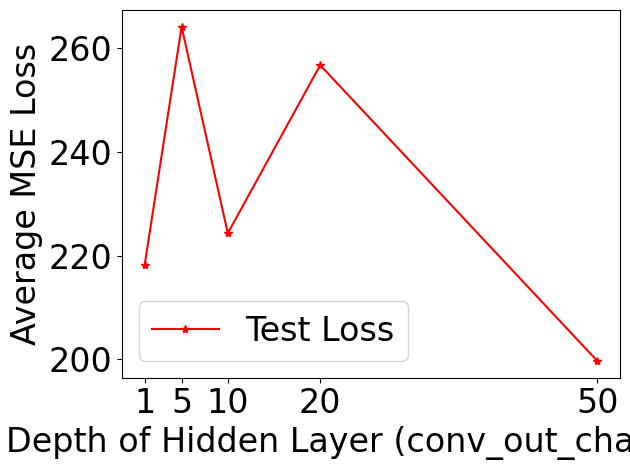

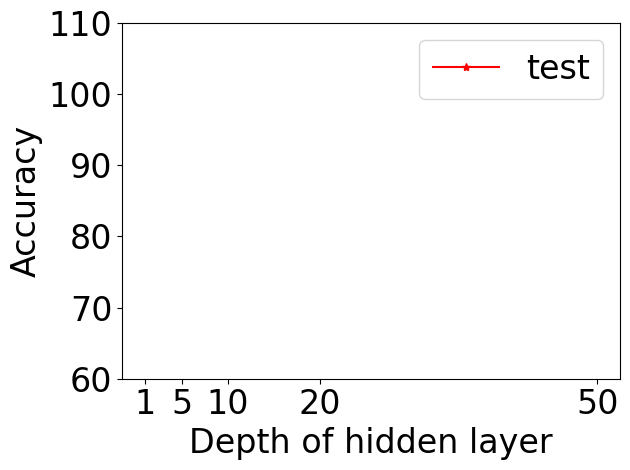

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

# Plot test loss for different conv_out_channels values.
plt.plot(N_array, test_array, 'r-*', label="Test Loss")
    
plt.xlabel('Depth of Hidden Layer (conv_out_channels)', fontsize=24)
plt.xticks(N_array)
plt.ylabel('Average MSE Loss', fontsize=24)
plt.legend(loc='best', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.tight_layout()
plt.show()


plt.plot(N_array, test_array, 'r-*', label="test")
plt.ylim(60,110)
plt.xlabel('Depth of hidden layer', fontsize=24)
plt.xticks(N_array)
plt.ylabel('Accuracy', fontsize=24)
plt.legend(loc='best', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.tight_layout()
plt.show()

For conv_out_channels = 1:

During the 5 training epochs, the batch loss started at around 0.0273 and decreased to around 0.00457.
The test set’s average loss was about 0.0050 at the end of training.
These numbers tell you that with only 1 convolutional filter, the model still learns to reduce the MSE to around 0.005.
For conv_out_channels = 5:

Training started with a loss of about 0.01071 and dropped to around 0.00509 by epoch 5.
The test loss for this configuration was around 0.0053.
Notice that the training and test losses are fairly similar to the previous configuration; slight differences might be due to increased capacity.
For conv_out_channels = 10:

Here the training loss starts at roughly 0.01080 and decreases to around 0.00375.
The test loss goes as low as 0.0035.
This configuration seems to yield a lower test loss, which may indicate that with 10 filters, the model better captures the useful features from the sequence input.
For conv_out_channels = 20:

Training loss is initially a bit higher (around 0.03101) and then decreases to approximately 0.00402 by the final epoch.
The test loss is around 0.0055.
A slightly higher test loss compared to the 10-filter case might suggest that increasing the filter count further doesn’t necessarily improve performance—perhaps due to overfitting or because the extra capacity isn’t needed.
For conv_out_channels = 50:

The test losses recorded include a value of about 0.00549.
No training logs are shown here (other than the test losses), but you see the overall performance is recorded.
Critical losses:

Throughout, the "Critical losses" array remains empty. This indicates that you either did not define or pass in a critical dataset loader, so no evaluation on a “critical” dataset was performed.
What It Tells You
Training Progress:
The decreasing training loss over epochs shows that the model is learning on the training data.

Generalization:
The test losses, which are in a similar range (generally between ~0.0035 and ~0.0055), indicate that the model generalizes reasonably well on the test set for most configurations.

Impact of Convolutional Depth:
Changing the number of convolutional filters (conv_out_channels) affects the learning process. For example, a setting of 10 filters resulted in the lowest test loss (around 0.0035)

Epoch Logs:
Show batch training progress and loss reduction over epochs.

Test Loss:
Provides a measure of the model’s performance on unseen data, with lower MSE indicating better predictions.

Mean Squared Error: 199.6493
Mean Absolute Error: 13.6272
R² Score: -5.8686


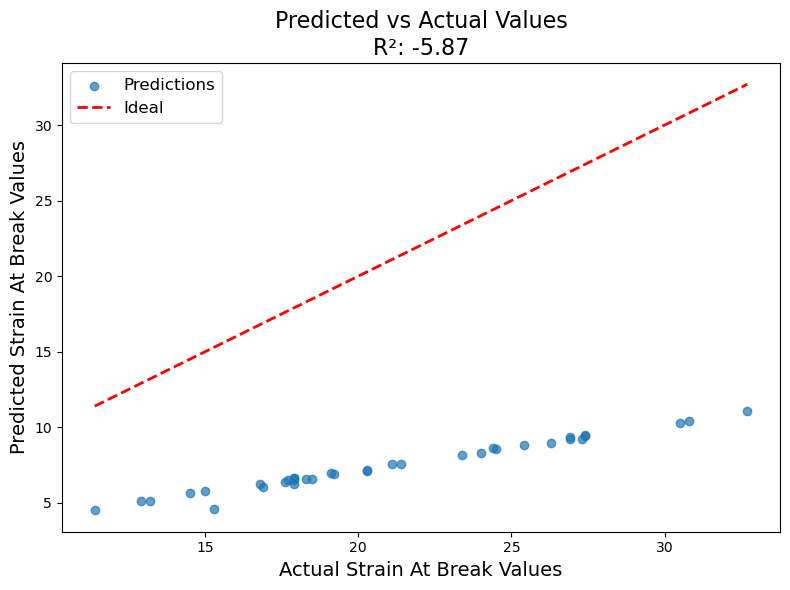

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Set the model to evaluation mode.
model.eval()

preds = []
actuals = []

# Iterate over the test data loader and collect predictions.
with torch.no_grad():
    for sample in test_loader:
        # Move tensors to CUDA if needed.
        if args.cuda:
            sample = {key: value.cuda() if isinstance(value, torch.Tensor) else value 
                      for key, value in sample.items()}
        output = model(sample)  # Output shape: (batch, 1)
        preds.append(output.cpu().numpy())
        actuals.append(sample['target'].cpu().numpy())

# Flatten the predictions and actual values into 1D arrays.
preds = np.concatenate(preds).flatten()
actuals = np.concatenate(actuals).flatten()

# Compute metrics.
mse = mean_squared_error(actuals, preds)
mae = mean_absolute_error(actuals, preds)
r2 = r2_score(actuals, preds)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Create a scatter plot of actual vs. predicted values.
plt.figure(figsize=(8, 6))
plt.scatter(actuals, preds, alpha=0.7, label='Predictions')
# Plot an ideal line (y=x) for reference.
plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--', lw=2, label='Ideal')
plt.xlabel("Actual Strain At Break Values", fontsize=14)
plt.ylabel("Predicted Strain At Break Values", fontsize=14)
plt.title(f"Predicted vs Actual Values\nR²: {r2:.2f}", fontsize=16)
plt.legend(loc="best", fontsize=12)
plt.tight_layout()
plt.show()

In [10]:
model.eval()

# dummy padded sequence and a mechanical input.
import torch
dummy_sequence = torch.randint(0, 21, (1, 200))  # Randomly generated padded sequence (1 sample, length 200)
dummy_mechanical_input = torch.tensor([[0.5]])     # Example auxiliary input value

sample = {
    'sequence': dummy_sequence,
    'mechanical_input': dummy_mechanical_input,
    # Note: target is not needed during inference.
}

with torch.no_grad():
    prediction = model(sample)
    # Print out which mechanical property is being predicted.
    print(f"Predicted {args.target_property}: {prediction.item()}")
    
    # Decode the sequence from numeric tokens to letters.
    # Remove padding tokens (zeros) from the sequence.
    seq_tokens = sample['sequence'][0]  # Taking the first (and only) sample.
    decoded_seq = "".join([polarity_to_aa.get(token.item(), '-') for token in seq_tokens if token.item() != 0])
    print("Input AA Sequence:", decoded_seq)

Predicted strain_at_break: 1.0497801303863525
Input AA Sequence: IWRCPFHVVMPNNCFDEMPPDEHNVNCFYPVEYMELTRGKDIRQQSSPENEQPQFAHPRYTNTWTEFDHSTPATLHDIKCANSFQSLEPHKNFCTSHHKNQMYRNGVYWNIQIYAHWLIEIAFFWMDQLQKDVSACLYVFFCNQRANPCISDLWSSWDRPHTEDIRMSVQVMMDTMVFKNRHGA


In [11]:
import os
os.system("dot -V")
import os
os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"
print(os.environ["PATH"])

C:\Users\ameet\anaconda3\envs\spider;C:\Users\ameet\anaconda3\envs\spider\Library\mingw-w64\bin;C:\Users\ameet\anaconda3\envs\spider\Library\usr\bin;C:\Users\ameet\anaconda3\envs\spider\Library\bin;C:\Users\ameet\anaconda3\envs\spider\Scripts;C:\Users\ameet\anaconda3\envs\spider\bin;C:\Users\ameet\anaconda3\condabin;C:\Users\ameet\anaconda3;C:\Users\ameet\anaconda3\Library\mingw-w64\bin;C:\Users\ameet\anaconda3\Library\usr\bin;C:\Users\ameet\anaconda3\Library\bin;C:\Users\ameet\anaconda3\Scripts;C:\Program Files\RevvitySignalsSoftware\ChemDrawApplications\ChemScript\Lib;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\WindowsPowerShell\v1.0;C:\WINDOWS\System32\OpenSSH;C:\Program Files\dotnet;C:\Program Files\MATLAB\R2023b\bin;C:\Program Files\Git\cmd;C:\Users\ameet\AppData\Local\Microsoft\WindowsApps;C:\Program Files\Graphviz\bin;.;C:\Program Files\Graphviz\bin


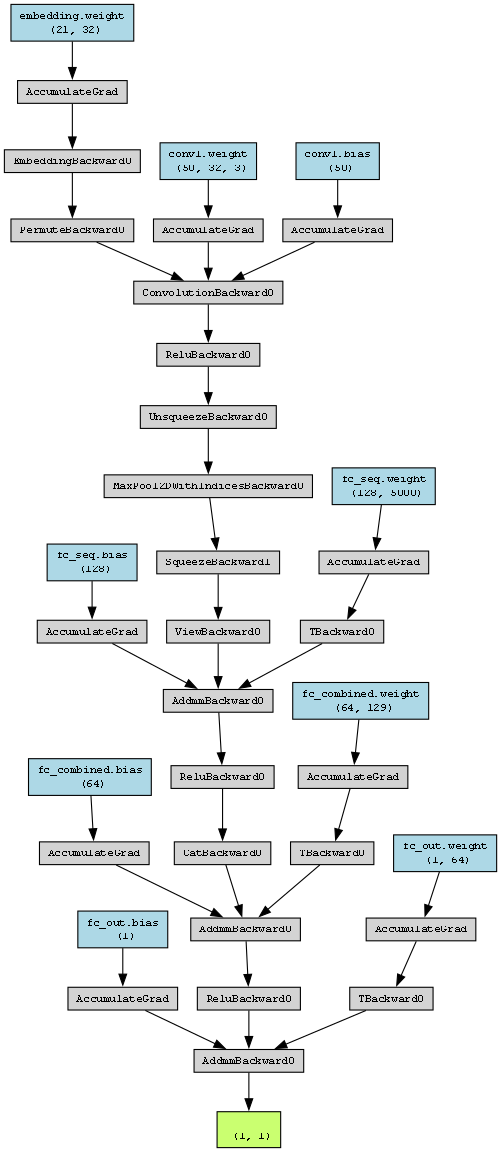

In [12]:
from torchviz import make_dot
import torch

# Create a dummy sample dictionary that matches your model input.
dummy_sample = {
    'sequence': torch.randint(0, 21, (1, 200)),  # One sample padded to length 200
    'mechanical_input': torch.tensor([[0.5]])     # Example auxiliary input
}

# Pass the dummy sample through the model.
output = model(dummy_sample)

# Visualize the computation graph.
dot = make_dot(output, params=dict(model.named_parameters()))
dot.render("cnn_model", format="png")  # 
from IPython.display import Image
Image("cnn_model.png")


Filter shape: (50, 32, 3)


C:\Users\ameet\AppData\Local\Temp\ipykernel_18352\3253493933.py:23: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


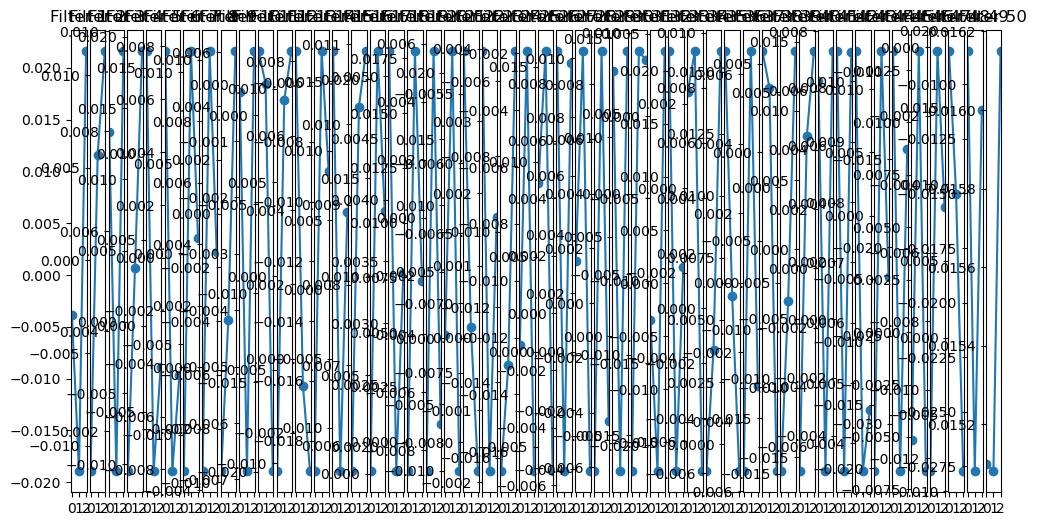

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Get the weights from your convolutional layer.
# For example, assuming your conv layer is model.conv1.
filters = model.conv1.weight.data.cpu().numpy()

# filters shape will be (conv_out_channels, in_channels, kernel_size)
conv_out_channels, in_channels, kernel_size = filters.shape
print("Filter shape:", filters.shape)

# Plot the filters.
plt.figure(figsize=(12, 6))
for i in range(conv_out_channels):
    plt.subplot(1, conv_out_channels, i + 1)
    # If in_channels is greater than 1, you might want to visualize each channel separately.
    # Here, we assume in_channels == embedding_dim (e.g., 32).
    # For simplicity, we average over channels.
    filter_avg = np.mean(filters[i], axis=0)
    plt.plot(filter_avg, marker='o')
    plt.title(f"Filter {i+1}")
    plt.xticks(range(kernel_size))
plt.tight_layout()
plt.show()


In [14]:
from torchsummary import summary
summary(model, input_data=[(1, 200), (1, 1)])  # Adjust based on input dimensions

TypeError: summary() got an unexpected keyword argument 'input_data'